In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.metrics as skl_met
import sklearn.model_selection as skl_ms
import sklearn.decomposition as skl_dec
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
from IPython.core.pylabtools import figsize
figsize(10, 6) # Width and hight
plt.style.use('seaborn-white')

In [4]:
train_url = 'training_data.csv'
train_df = pd.read_csv(train_url, na_values='?', dtype={'ID': str}).dropna().reset_index()

min_max_scaler = skl_pre.MinMaxScaler()
train_values = train_df.values #returns a numpy array
train_scaled = min_max_scaler.fit_transform(train_values)

train_df = pd.DataFrame(train_scaled,columns = list(train_df.columns.values)).drop(columns = 'index') #drop index
train_df.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
0,0.717303,0.463026,0.103325,0.519148,0.843847,0.727273,0.092147,0.507981,0.0,0.030103,0.432113,0.75,0.116585,1.0
1,0.193158,0.690557,0.269951,0.613492,0.000000,0.363636,0.250262,0.779758,1.0,0.012185,0.459671,0.75,0.582714,1.0
2,0.335009,0.594994,0.284262,0.452194,0.000004,0.454545,0.107853,0.698741,1.0,0.008314,0.567220,0.75,0.176046,1.0
3,0.604627,0.799772,0.159891,0.214811,0.217166,0.454545,0.167539,0.639741,1.0,0.027953,0.365280,0.75,0.812062,1.0
4,0.888330,0.407281,0.230079,0.456252,0.000179,0.545455,0.047330,0.738406,0.0,0.016772,0.236229,0.75,0.270546,1.0


In [5]:
X = train_df.drop(columns =['label'])
y = train_df['label']

n_fold = 10

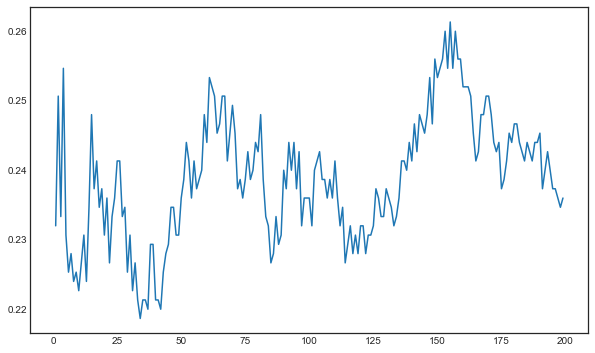

In [6]:
#Choose best k. Same procedure was done with random forest, using K = [0,10,20,40,60,80,100,130,150,180,200]
cv = skl_ms.KFold(n_splits = n_fold, random_state = 2, shuffle = True)
K = np.arange(1,200)
missclassification = np.zeros(len(K))
for train_index, val_index in cv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for j,k in enumerate(K):
        knn_model = skl_nb.KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
        y_pred = knn_model.predict(X_val)
        missclassification[j] += (np.mean(y_pred != y_val))
        
missclassification /= n_fold
plt.plot(K,missclassification)
plt.show()
#k around 30 gives a best result (30-40)

In [7]:
corr = train_df.corr()
print(corr)
#print(np.size(corr['label']))
corr_feat = corr.index

                  acousticness  danceability  duration    energy  \
acousticness          1.000000     -0.417974  0.054988 -0.781691   
danceability         -0.417974      1.000000 -0.231120  0.360971   
duration              0.054988     -0.231120  1.000000 -0.093435   
energy               -0.781691      0.360971 -0.093435  1.000000   
instrumentalness      0.331659     -0.238865  0.161803 -0.267846   
key                  -0.065184      0.055302 -0.002089  0.066970   
liveness             -0.140326     -0.115735 -0.002576  0.235887   
loudness             -0.695163      0.396021 -0.179952  0.830081   
mode                  0.111980     -0.058461 -0.011989 -0.102567   
speechiness          -0.215614      0.272283 -0.110645  0.173371   
tempo                -0.149472      0.064002 -0.052321  0.197741   
time_signature       -0.205854      0.222486 -0.003030  0.241667   
valence              -0.233485      0.483361 -0.256984  0.364495   
label                 0.479307     -0.368501  0.

In [8]:
label_corr = corr['label'].drop(index = 'label')
variables = len(label_corr)
order = abs(label_corr).sort_values(ascending = False).index

In [ ]:
#highest linear correlation value
models = [skl_lm.LogisticRegression(solver = 'liblinear'), skl_nb.KNeighborsClassifier(n_neighbors=16), skl_nb.KNeighborsClassifier(n_neighbors=35), skl_da.LinearDiscriminantAnalysis(), skl_da.QuadraticDiscriminantAnalysis()
, RandomForestClassifier(n_estimators = 150), BaggingClassifier(), '1:s']
model_labels = ['LogReg. ', 'kNN, k = 16. ', 'kNN, k = 35. ', 'LDA. ', 'QDA.', 'Random Forest, n = 150.','Bagging.', '1:s.']

for mi, model in enumerate(models):
    print('\n',model_labels[mi], '\n')
    model_label = model_labels[mi]
    missclassifications = []
    
    for i in range(1,len(order)+1):
        X_bf = X[order[0:i]] #bf = brute_force
    
        missclassification = 0
        for train_index, val_index in cv.split(X_bf):
            X_train, X_val = X_bf.iloc[train_index], X_bf.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            if not type(model) == str:
                model.fit(X_train,y_train)
                y_pred = model.predict(X_val)
            else:
                y_pred = np.array(np.repeat(1,len(X_val)))
                
            missclassification += (np.mean(y_pred != y_val))
        
        missclassification /= n_fold
        missclassifications.append(missclassification)
        print('Features: ', i, 'Missclassification error mean: ', missclassification)


 LogReg.  

Features:  1 Missclassification error mean:  0.24666666666666667
Features:  2 Missclassification error mean:  0.22533333333333333
Features:  3 Missclassification error mean:  0.22133333333333333
Features:  4 Missclassification error mean:  0.21200000000000002
Features:  5 Missclassification error mean:  0.19466666666666668
Features:  6 Missclassification error mean:  0.20133333333333336
Features:  7 Missclassification error mean:  0.19733333333333333
Features:  8 Missclassification error mean:  0.19866666666666663
Features:  9 Missclassification error mean:  0.1973333333333333
Features:  10 Missclassification error mean:  0.19866666666666663
Features:  11 Missclassification error mean:  0.19466666666666668
Features:  12 Missclassification error mean:  0.19733333333333336
Features:  13 Missclassification error mean:  0.19333333333333336

 kNN, k = 16.  

Features:  1 Missclassification error mean:  0.2693333333333333
Features:  2 Missclassification error mean:  0.18
Feature

In [ ]:
#check if transformations create larger correlation value
transformations = [np.square, np.sqrt, lambda x: np.log10(x+1), np.exp, np.sin, lambda x: np.power(x,3)]
correlations = pd.DataFrame(label_corr)#, columns =['0'])#, index = list(label_corr.index))
correlations.columns = ['untouched']
max_correlations = correlations.copy()
#perform all transformations
for j,t in enumerate(transformations):
    transformed_df = train_df.transform(t)
    corr_t = transformed_df.corr()
    label_corr_t = corr_t['label'].drop(index = 'label')
    correlations[j] = label_corr_t
    #print(correlations)
    
#for every index decide highest correlation

best_corr = pd.Series()
best_corr_index = pd.Series()
for index in correlations.index:
    corr_comp = correlations.loc[index]
    order_corr = abs(corr_comp).sort_values(ascending = False).index
    max_corr_i = order_corr[0]
    max_corr = corr_comp[max_corr_i]
    #print(max_corr_i,max_corr)
    best_corr[index] = max_corr
    best_corr_index[index] = max_corr_i
    #print(best_corr)

max_correlations['best_corr'] = best_corr
max_correlations['transformation_index'] = best_corr_index
order_transformed = abs(max_correlations['best_corr']).sort_values(ascending = False).index

#print(max_correlations)

#create new df and new order
transf_df = train_df.copy() #change to test of used for final test
for index in correlations.index:
    row = max_correlations.loc[index]
    t_i = row['transformation_index']
    if(not t_i == 'untouched'):
        transf = transformations[t_i]
        col = transf_df[index].transform(transf)
        transf_df[index] = col
#out: transf_df, order_transformed
print('Transformed order:', '\n', order_transformed, '\nUntransformed order: \n', order)
    

In [ ]:
X_trans = transf_df.drop(columns =['label'])
y_trans = transf_df['label']
order_tf = order_transformed
model_labels = ['LogReg. Transformed Data.', 'kNN, k = 16. Transformed Data.', 'kNN, k = 35. Transformed Data.', 'LDA. Transformed Data.', 'QDA. Transformed Data.', 'Random Forest, n = 150. Transformed Data.','Bagging. Transformed Data.','1:s.']

for mi, model in enumerate(models):
    print('\n',model_labels[mi], '\n')
    model_label = model_labels[mi]
    missclassifications = []
    
    for i in range(1,len(order)+1):
        X_bf = X_trans[order_tf[0:i]] #bf = brute_force
    
        missclassification = 0
        for train_index, val_index in cv.split(X_bf):
            X_train, X_val = X_bf.iloc[train_index], X_bf.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
            if not type(model) == str:
                model.fit(X_train,y_train)
                y_pred = model.predict(X_val)
            else:
                y_pred = np.array(np.repeat(1,len(X_val)))
            missclassification += (np.mean(y_pred != y_val))
       
        
        missclassification /= n_fold
        missclassifications.append(missclassification)
        print('Features: ', i, 'Missclassification error mean: ', missclassification)

In [ ]:
#Choose best k. Same procedure was done with random forest, using K = [0,10,20,40,60,80,100,130,150,180,200]

cv = skl_ms.KFold(n_splits = n_fold, random_state = 2, shuffle = True)
K = np.arange(1,200)
missclassification = np.zeros(len(K))
for train_index, val_index in cv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for j,k in enumerate(K):
        knn_model = skl_nb.KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
        y_pred = knn_model.predict(X_val)
        missclassification[j] += (np.mean(y_pred != y_val))
        
missclassification /= n_fold
plt.plot(K,missclassification)
plt.show()
#k around 30 gives a best result (30-40)

In [ ]:
#final train with variable choice
#print(lowest_missclassification,missc_index)
#k = missc_k
var = 11#missc_index + 1

test_url = 'songs_to_classify.csv'
test_df = pd.read_csv(test_url, na_values='?', dtype={'ID': str}).dropna().reset_index()

test_values = test_df.values
test_scaled = min_max_scaler.fit_transform(test_values)

test_df = pd.DataFrame(test_scaled,columns = list(test_df.columns.values))#.drop(columns = 'index')
#print(train_f_df.head())

X_test = test_df[order[0:var]]
#print(X_test_final.shape)
#print(X_test_final.head())

X_train = X[order[0:var]]
y_train = y

#knn_model = skl_nb.KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
#y_pred = knn_model.predict(X_test)
#
model_bag = RandomForestClassifier(n_estimators = 150)#BaggingClassifier()
model_bag.fit(X_train,y_train)
y_pred = model_bag.predict(X_test)
        
ans = np.array2string(y_pred).replace('\n','').replace('.','').replace(' ','').replace('[','').replace(']','')
ans_list = list(ans)
print(ans_list.count('0'), ans_list.count('1'))
print(ans)

In [ ]:
#final train with variable choice, transformed model/var

#print(lowest_missclassification,missc_index, missc_k)
#opt_k = missc_k

#opt_k = K[missc_k]
#print(lowest_missclassification,missc_index, opt_k)

opt_k = 35
var_amount = 8
#var_amount = missc_index + 1

var_index = order_transformed[0:var_amount]

test_url = 'songs_to_classify.csv'
test_df = pd.read_csv(test_url, na_values='?', dtype={'ID': str}).dropna().reset_index()

test_values = test_df.values
test_scaled = min_max_scaler.fit_transform(test_values)

test_df = pd.DataFrame(test_scaled,columns = list(test_df.columns.values))#.drop(columns = 'index')
#print(train_f_df.head())

X_test = test_df[var_index]
#print(X_test.head())
for index in var_index:
    row = max_correlations.loc[index]
    t_i = row['transformation_index']
    if(not t_i == 'untouched'):
        transf = transformations[t_i]
        col = X_test[index].transform(transf)
        X_test[index] = col
#print(X_test.head())

print(X_test.shape)
#print(X_test_final.head())

X_train = X_trans[var_index]
y_train = y

knn_model = skl_nb.KNeighborsClassifier(n_neighbors=opt_k).fit(X_train,y_train)
y_pred = knn_model.predict(X_test)

#model_rf = RandomForestClassifier(n_estimators = opt_k)
#model_rf.fit(X_train,y_train)
#y_pred = model_rf.predict(X_test)

ans = np.array2string(y_pred).replace('\n','').replace('.','').replace(' ','').replace('[','').replace(']','')
ans_list = list(ans)
print(ans_list.count('0'), ans_list.count('1'))
#print(y_pred,type(y_pred), np.array2string(y_pred).replace('. ','').replace('.\n','').replace('.','').replace(' ',''),len(np.array2string(y_pred)))
print(ans)